(np.float64(-0.5), np.float64(472.5), np.float64(303.5), np.float64(-0.5))

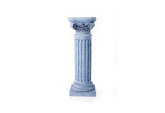

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from scipy.spatial.distance import cdist
from scipy import interpolate

root = os.getcwd()
image_path = os.path.join("C:\\Users\\ryanm\\Documents\\Rmvi\\animation\\video\\fourier\\Image\\pilone_grec.jpg")
image = cv2.imread(image_path)
plt.figure()
plt.subplot(231)
plt.imshow(image)
plt.axis('off')

# Suppression du bg

In [25]:
from rembg import remove
from PIL import Image

# Store path of the image in the variable input_path
input_path =  image_path

# Store path of the output image in the variable output_path
output_path = "C:\\Users\\ryanm\\Documents\\Rmvi\\animation\\video\\fourier\\Image\\helene_no_bg.png"

# Processing the image
input = Image.open(input_path)

# Removing the background from the given Image
output = remove(input)

#Saving the image in the given path
output.save(output_path)


### Extraction et visualisation des contours

Permet d'obtenir les **contours principaux** de la photo à l'aide d'une détection par gradient,  
puis de les **afficher séparément** pour faciliter l'analyse et le choix des paramètres (`stop`, `tresh`, `mindist`).
 

In [26]:
# use np and cv2 to have a list of list containing contours
# the code turn colors into black and white and then find contous
# all these contours are closed one but each list may be appart of each other

def getnShowContours(image, treshold = 120, maxval = 255, kernelSize = 7, show = True, border_margin=5):
    _,tresh = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), treshold, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((kernelSize,kernelSize), np.uint8)
    tresh = cv2.dilate(tresh, kernel, iterations=1)
    contours, _ = cv2.findContours(tresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    h, w = image.shape[:2]
    filtered_contours = []
    for c in contours:
        new_c = []
        for pt in c:
            x, y = pt[0]
            if border_margin <= x <= w - border_margin and border_margin <= y <= h - border_margin:
                new_c.append([[x, y]])
        if new_c:  # contour non vide
            filtered_contours.append(np.array(new_c, dtype=np.int32))

    # Tri par taille décroissante
    filtered_contours = sorted(filtered_contours, key=len, reverse=True)

    if show :
        blank_black = np.zeros_like(image)
        cv2.drawContours(blank_black, filtered_contours, -1, (255, 255, 255), 2)
        plt.imshow(cv2.cvtColor(blank_black, cv2.COLOR_BGR2RGB))
        plt.title("Contours sur fond noir")
    return filtered_contours

# show each contours separately
def showContours(contours, image, max_cols=4, base_size=3):
    """
    Affiche plusieurs contours sur fond noir.
    La taille globale s'adapte automatiquement au nombre de contours.
    """
    n = len(contours)
    cols = min(max_cols, n)
    rows = (n + cols - 1) // cols

    fig_width = base_size * cols
    fig_height = base_size * rows
    plt.figure(figsize=(fig_width, fig_height))

    for i, contour in enumerate(contours):
        blank = np.zeros_like(image)
        cv2.drawContours(blank, [contour], -1, (255, 255, 255), 2)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(blank, cv2.COLOR_BGR2RGB))
        plt.title(f"Contour {i+1} ({len(contour)} pts)", fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

[array([[[199,  24]],
 
        [[199,  25]],
 
        [[199,  26]],
 
        ...,
 
        [[202,  24]],
 
        [[201,  24]],
 
        [[200,  24]]], shape=(736, 1, 2), dtype=int32)]

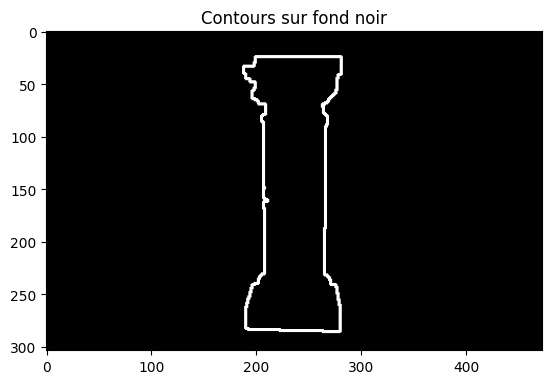

In [27]:
getnShowContours(image, treshold= 200)

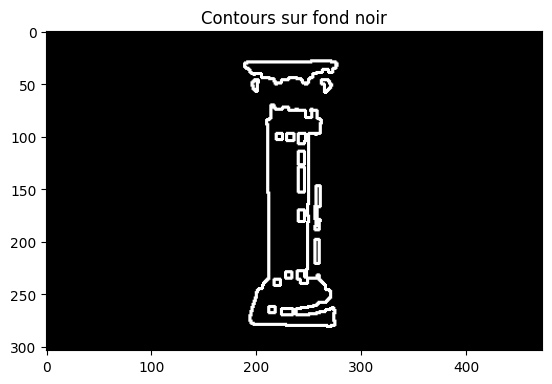

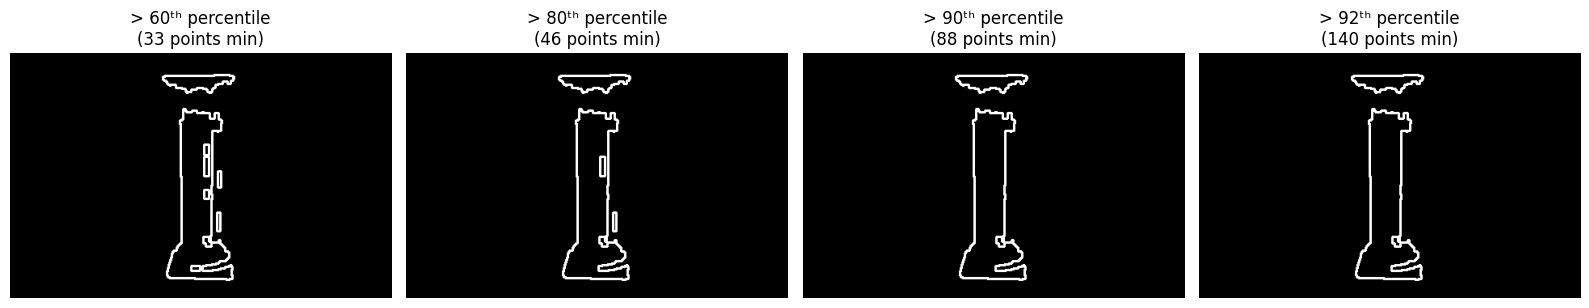

Seuils utilisés : [ 33.8   46.4   88.6  140.08]


In [28]:
def show_long_contours_by_percentile(image, percentiles=[50, 75, 90, 95], treshold = 120):
    """
    Affiche les contours dont la longueur dépasse certains percentiles.
    Permet de visualiser l'effet du filtrage par taille.
    """
    # Récupération des contours
    contours = getnShowContours(image, treshold = treshold)
    lengths = np.array([len(c) for c in contours])

    # Calcul des seuils de longueur pour chaque percentile
    thresholds = np.percentile(lengths, percentiles)

    # Création d'une figure par percentile
    n = len(percentiles)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    
    for i, (p, thresh) in enumerate(zip(percentiles, thresholds)):
        # Sélection des contours assez longs
        long_contours = [c for c in contours if len(c) >= thresh]
        
        # Image noire + dessin
        blank_black = np.zeros_like(image)
        cv2.drawContours(blank_black, long_contours, -1, (255, 255, 255), 2)
        
        # Affichage
        ax = axes[i] if n > 1 else axes
        ax.imshow(cv2.cvtColor(blank_black, cv2.COLOR_BGR2RGB))
        ax.set_title(f"> {p}ᵗʰ percentile\n({int(thresh)} points min)")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

    return thresholds
image = cv2.imread(output_path)
thresholds = show_long_contours_by_percentile(image, percentiles=[60, 80, 90, 92], treshold = 85)
print("Seuils utilisés :", thresholds)

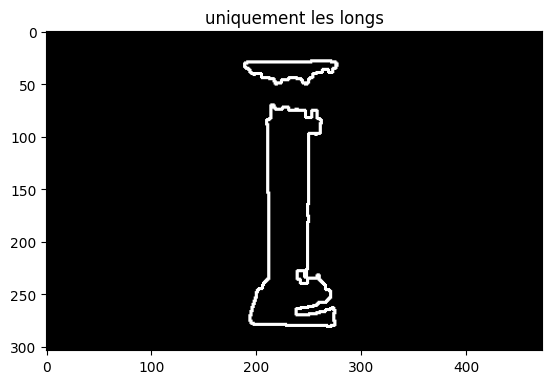

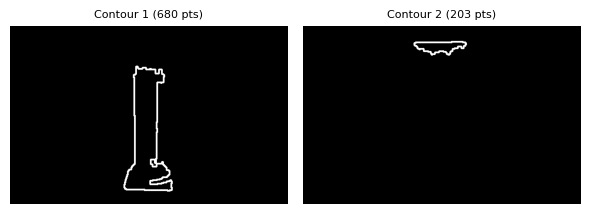

In [29]:
contours = getnShowContours(image,treshold = 85)
long_contours = []
for contour in contours:
    if(len(contour)> 162): long_contours.append(contour)
blank_black = np.zeros_like(image)
cv2.drawContours(blank_black, long_contours, -1, (255, 255, 255), 2)
plt.imshow(cv2.cvtColor(blank_black, cv2.COLOR_BGR2RGB))
plt.title("uniquement les longs")

showContours(long_contours,image)

### Detection des coins

On utilise ce qu'on définis comme la pseudo dérivé qui calcule la dérivée à droite et à gauche. Dans un coin comme il y'a changement d'orientation elles ne doivent oas coincider. Etant donnée que les calculs sont en pixels on utilise la moyenne de la direction sur les "start - stop" à gauche et à droite. On conserve le premier "coin" trouvé et supprime ceux qui ne sont pas au moins à une distance de "mindist". Il faudrait modifier le code pour conserver celui qui dans une sphère de min dist à le gradient le plus élevé plutot que le premier
* on notera toutefois que l'écart en pixel par cette approximation quick n dirty est de maximum (stop - start)/2 pixels. Soit 4 pixels pour les paramètres par défauts


In [82]:
# it calculs the normalised difference between two position
def pseudoDerivate(vector1,vector2,n):
    dx = (vector2[0] - vector1[0])/n
    dy = (vector2[1] - vector1[1])/n
    return np.array([dx,dy])
# At a corner, the derivative on the right side differs from the one on the left.
# Therefore, if the average pseudo-derivative on the right deviates from the left
# by more than a given threshold, the point is considered an edge.
#
# Because we use an average over multiple neighboring points, the actual corner
# and its surrounding points are all likely to exceed the threshold.
# To avoid detecting the same corner multiple times, we enforce that
# consecutive detected edges must be at least 'mindist' apart.
# 
# Note : we should modify the code to only keep the one with the higest pseudo derivate on the same neigbour
def edgeDetection(contour, start=1, stop=10, tresh=0.25, mindist = 3, step = 20):
    edges = np.empty((0, 2))
    n = len(contour)  # longueur totale du contour
    count = 0
    for i in range(n):
        forw = np.zeros(2)
        backw = np.zeros(2)
        for j in range(start, stop):
            idx_forward = (i + j) % n
            idx_backward = (i - j) % n
            forw += pseudoDerivate(contour[i][0], contour[idx_forward][0], j)
            backw += pseudoDerivate(contour[i][0], contour[idx_backward][0], j)
        avg = (forw + backw) / (2 * (stop - start))
        # Si la norme de la moyenne dépasse le seuil
        if np.linalg.norm(avg) > tresh:
            if edges.size == 0 or np.linalg.norm(edges[-1] - contour[i][0]) > mindist:
                edges = np.vstack((edges, contour[i][0]))
                count = 0
        else:
            count += 1
            if count >= step:
                edges = np.vstack((edges, contour[i][0]))
                count = 0
    return edges


### Peut être utilisé pour trouver les bons paramètres

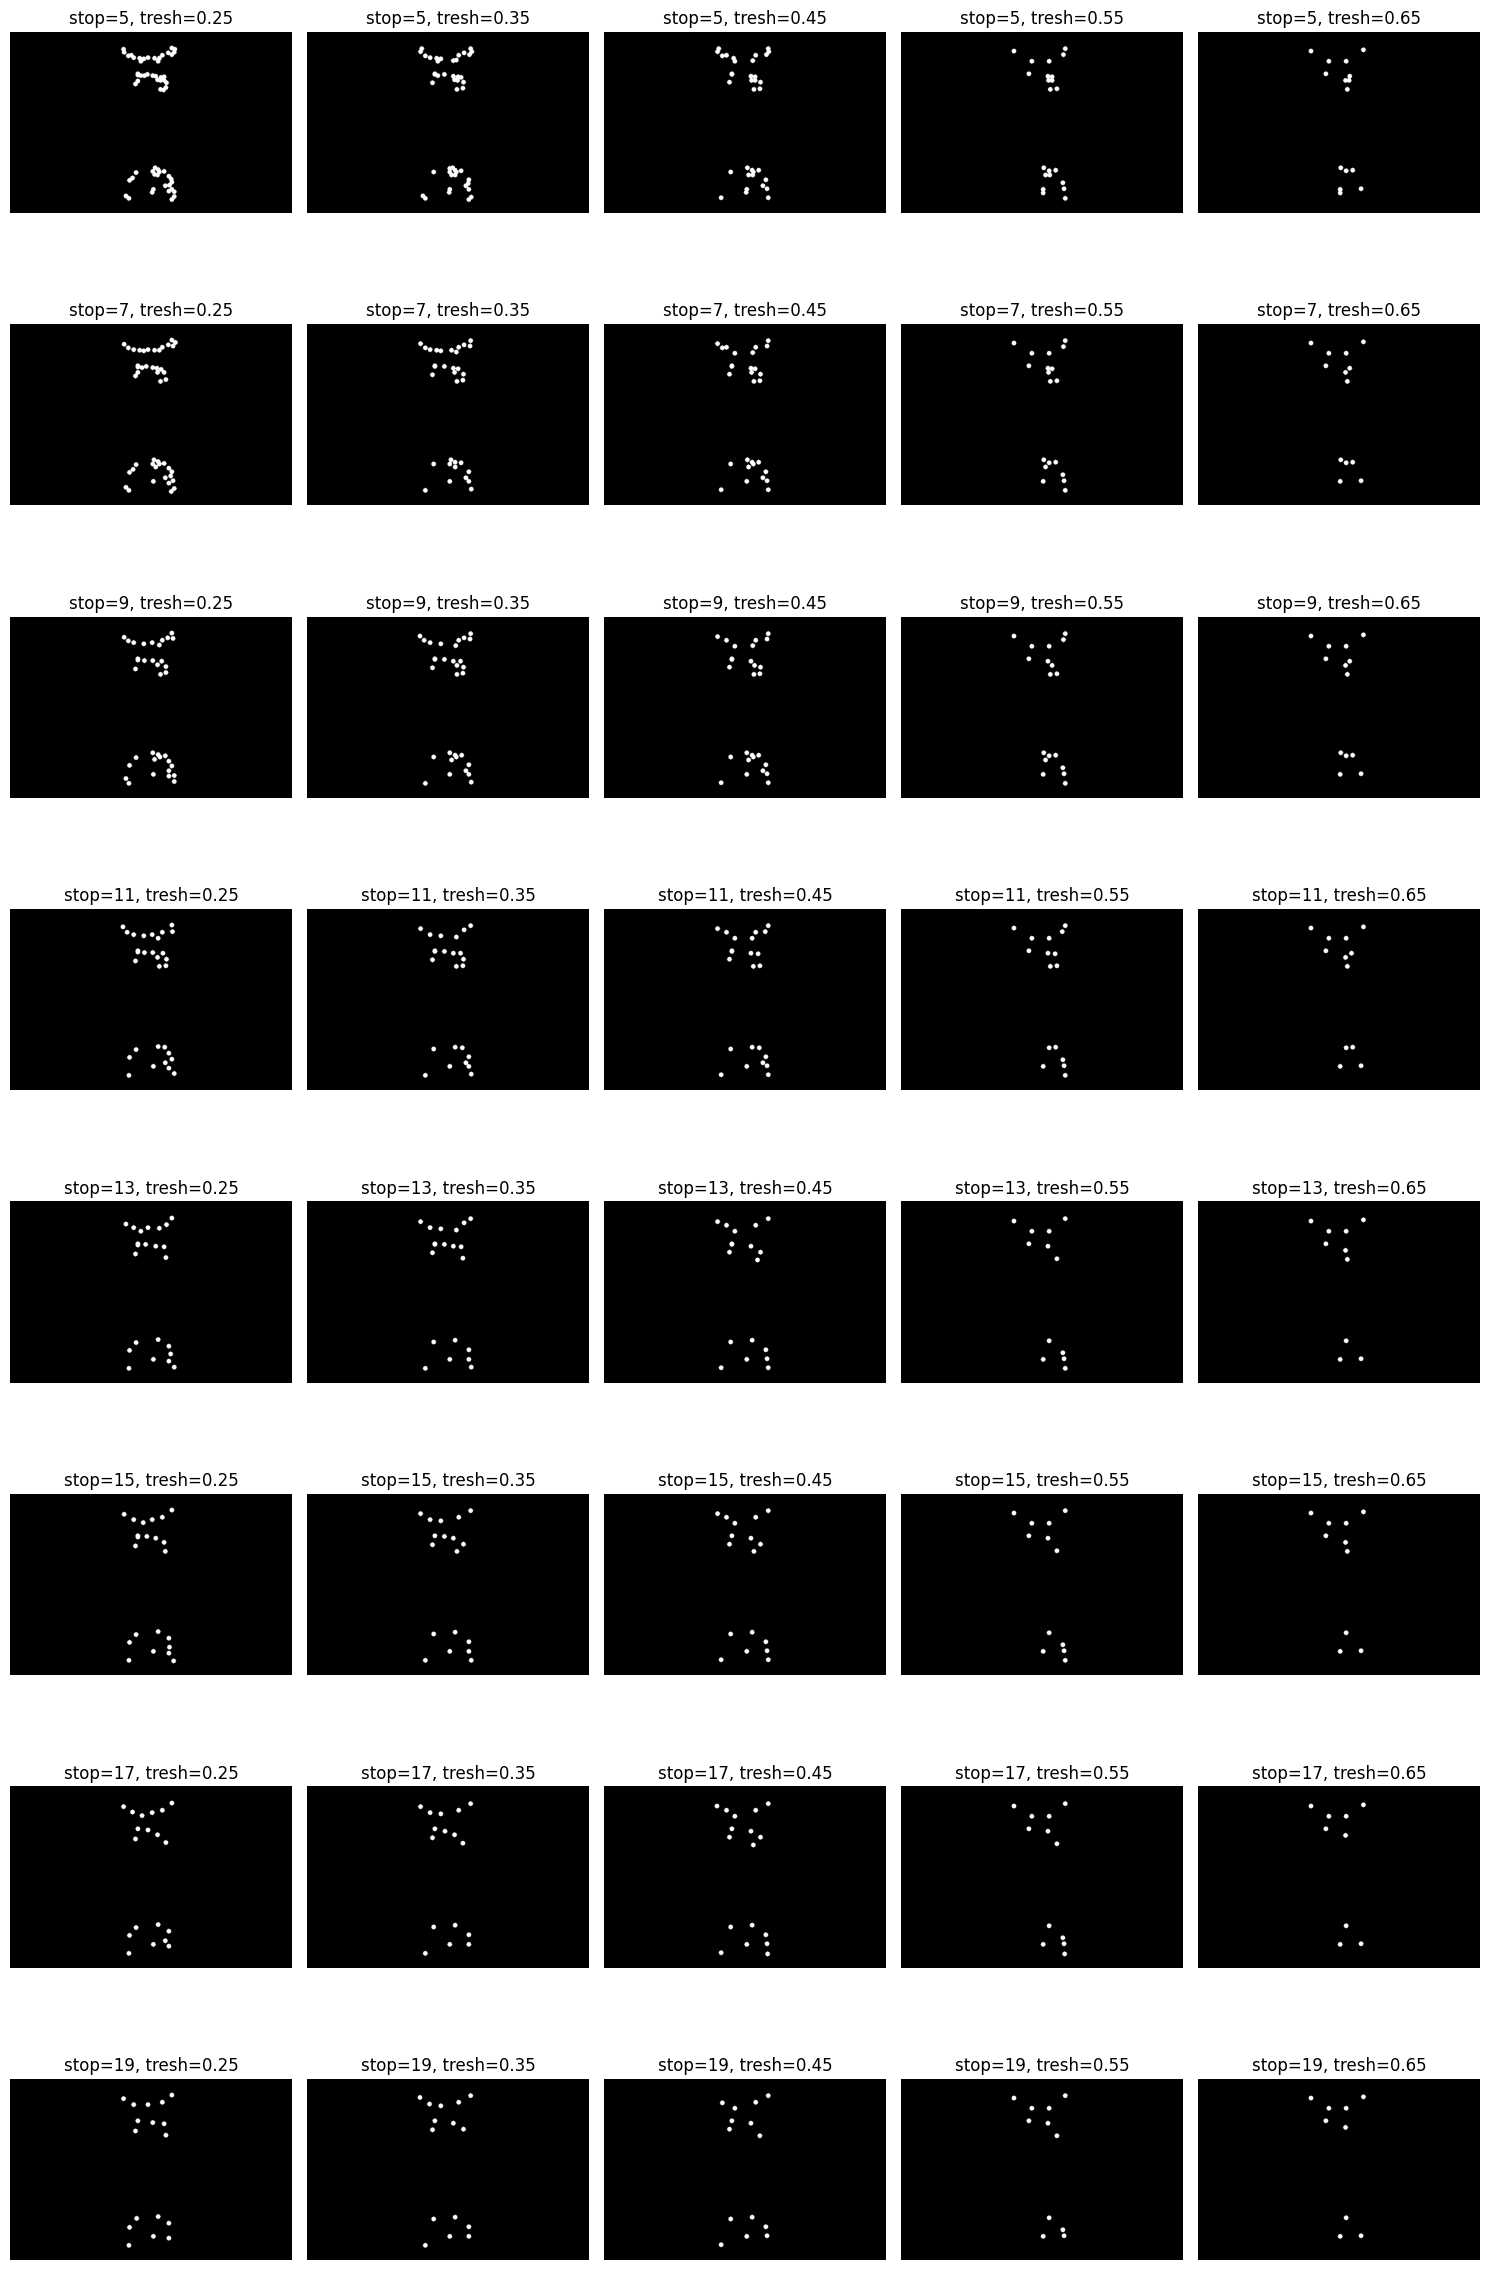

In [31]:
# allow to choose best parameters
dist_values = list(range(5, 21, 2))  # de 5 à 20 par pas de 2
tresh_values = np.arange(0.25, 0.71, 0.1)  # de 0.25 à 0.7 par pas de 0.1

# Taille de la grille pour les graphiques
n_rows = len(dist_values)
n_cols = len(tresh_values)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))

for i, stop in enumerate(dist_values):
    for j, tresh in enumerate(tresh_values):
        merged = []
        for k in range(len(long_contours)):
            if k not in [4, 5]:
                edges = edgeDetection(long_contours[k], stop=10, tresh=tresh, mindist=stop)
                merged.extend(edges)

        # Création d'une image noire
        blank_black = np.zeros_like(image)

        # Dessin des points uniquement (en blanc)
        for pt in merged:
            # Gestion des deux cas possibles : pt = [x, y] ou pt = [[x, y]]
            if isinstance(pt[0], (list, np.ndarray)):
                x, y = int(pt[0][0]), int(pt[0][1])
            else:
                x, y = int(pt[0]), int(pt[1])
            cv2.circle(blank_black, (x, y), radius=4, color=(255, 255, 255), thickness=-1)

        # Affichage
        ax = axes[i, j]
        ax.imshow(cv2.cvtColor(blank_black, cv2.COLOR_BGR2RGB))
        ax.set_title(f"stop={stop}, tresh={tresh:.2f}")
        ax.axis("off")

plt.tight_layout()
plt.show()


In [32]:
# allow a circular transition of index
def rotate_points(points, n):
    n = n % len(points)
    return np.roll(points, shift=-n, axis=0)

def align_contours(A, B):
    # Matrice des distances entre chaque point de A et chaque point de B
    dist_matrix = cdist(A, B)
    i, j = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
    # Décalage de B pour commencer au point j
    B_rot = rotate_points(B, j)
    # On choisit si on "reverse" B pour avoir continuité plus fluide
    if np.linalg.norm(A[i-1] - B_rot[0]) < np.linalg.norm(A[i-1] - B_rot[-1]):
        merged = np.vstack((A[:i], B_rot, A[i:]))
    else:
        merged = np.vstack((A[:i], B_rot[::-1], A[i:]))
    return merged

def smooth_closed_curve(points, smoothness=0.001, resolution=2000):
    """
    Génère une courbe lisse fermée à partir d'une série de points (x,y)
    via une B-spline périodique.
    """
    # S'assurer que le contour est bien fermé
    if not np.allclose(points[0], points[-1]):
        points = np.vstack([points, points[0]])
    # Extraire x et y
    x, y = points[:, 0], points[:, 1]
    # Créer la B-spline fermée
    tck, _ = interpolate.splprep([x, y], s=smoothness, per=True)
    u_new = np.linspace(0, 1, resolution)
    x_new, y_new = interpolate.splev(u_new, tck, der=0)
    return x_new, y_new

def save_smooth_to_csv(x, y, n, filename="ryan_jupyter.csv", delimiter=','):
    length = 2**n
    indices = np.linspace(0, len(x) - 1, length, dtype=int)
    # Sélectionne les points et centre
    x_s = x[indices] - np.mean(x[indices])
    y_s = y[indices] - np.mean(y[indices])
    # Combine les colonnes pour sauvegarde
    data = np.column_stack((x_s, y_s))
    np.savetxt(filename, data, delimiter=delimiter, fmt="%.15f")
    print(f"✅ Fichier enregistré : {filename} ({length} points)")
    return data

def save_array_to_csv(array, filename = "ryan_jupyter.csv", delimiter=','):
    all_points = np.vstack(array).astype(float)
    centered = all_points - np.mean(all_points, axis=0)
    centered[:, 1] = -centered[:, 1]
    np.savetxt(filename, centered, delimiter=",", fmt="%.15f")
    print(f"✅ Fichier enregistré : {filename}")
    return centered


In [91]:
def main(image, outputName, lengthMin=20, start=1, stop=10, tresh=0.3, mindist=15, treshold = 85, format = "spline"):
    """
    Pipeline complet :
    - Extraction des contours
    - Détection des arêtes (edges)
    - Visualisation
    - Lissage B-spline périodique
    - Export CSV
    """
    contours = getnShowContours(image, treshold= treshold)
    long_contours = [c for c in contours if len(c) > lengthMin] if lengthMin > 0 else contours

    # Détection des arêtes sur chaque contour
    edgesContours = [edgeDetection(c, start, stop, tresh, mindist, step= 10) for c in long_contours]

    # Visualisation des contours sélectionnés
    showContours(long_contours, image)

    # Affichage des points d'arêtes détectés
    blank_black = np.zeros_like(image)
    for contour_edges in edgesContours:
        for p in contour_edges:
            cv2.circle(blank_black, tuple(np.int32(p)), 4, (255, 255, 255), -1)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(blank_black, cv2.COLOR_BGR2RGB))
    plt.title("Points détectés comme arêtes")
    plt.axis("off")
    plt.show()

    # Fusion progressive des contours alignés
    interim = edgesContours[0]
    for edges in edgesContours[1:]:
        interim = align_contours(interim, edges)

    # Conversion et lissage
    curveTest = np.array(interim)
    curveTest[:, 1] = -curveTest[:, 1]
    x_smooth, y_smooth = smooth_closed_curve(curveTest, smoothness=0.01, resolution=3000)

    # Affichage final
    plt.figure(figsize=(8, 8))
    plt.style.use('dark_background')
    plt.plot(x_smooth, y_smooth, color='white', linewidth=2)
    plt.axis('equal')
    plt.title("Courbe fermée lissée (B-spline périodique)")
    plt.show()

    # Sauvegarde
    if format == "spline":
        save_smooth_to_csv(x_smooth, y_smooth, 9, outputName)
    elif format == "edges":
        save_array_to_csv(interim, outputName)

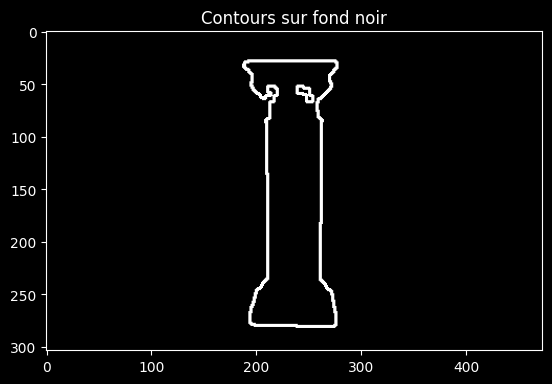

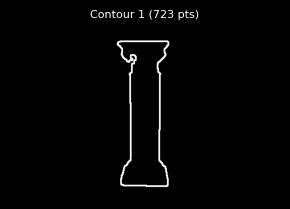

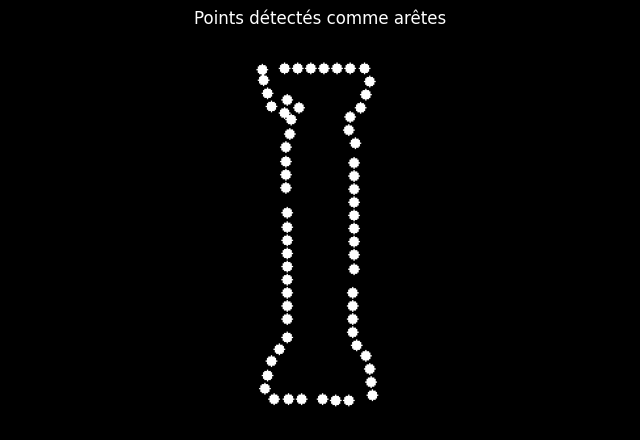

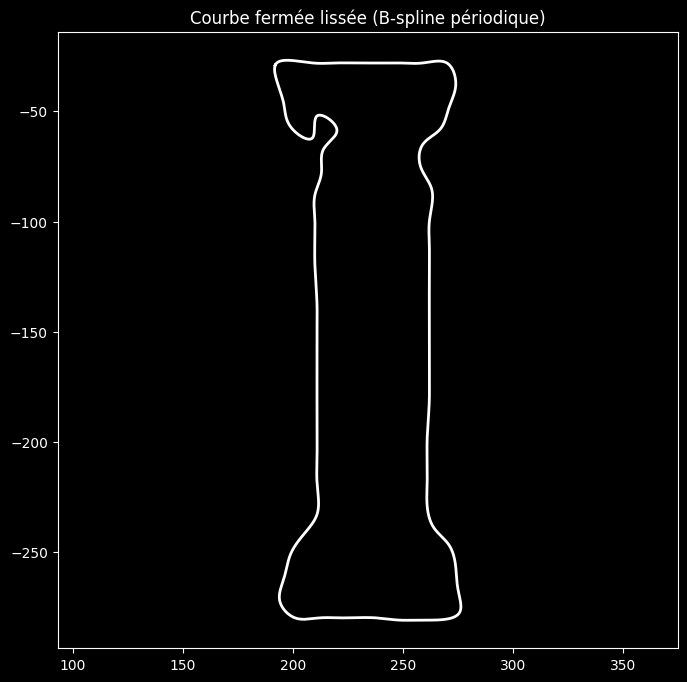

✅ Fichier enregistré : ..\video\fourier\Image\pilone_grec.csv


In [92]:
main(image,"..\\video\\fourier\\Image\\pilone_grec.csv",lengthMin = 60, tresh=0.02, mindist = 10, treshold= 20, format="edges")

[array([[211.,  28.],
        [231.,  28.],
        [251.,  28.],
        [271.,  28.],
        [270.,  45.],
        [260.,  64.],
        [261.,  83.],
        [262., 103.],
        [262., 123.],
        [262., 143.],
        [262., 163.],
        [261., 183.],
        [261., 203.],
        [261., 223.],
        [267., 243.],
        [274., 261.],
        [274., 281.],
        [254., 281.],
        [234., 280.],
        [214., 280.],
        [194., 277.],
        [198., 257.],
        [207., 239.],
        [211., 219.],
        [211., 199.],
        [211., 179.],
        [211., 159.],
        [211., 139.],
        [210., 119.],
        [210.,  99.],
        [213.,  81.],
        [217.,  64.],
        [213.,  52.],
        [208.,  64.],
        [196.,  46.],
        [188.,  33.]]),
 array([[239.,  52.],
        [248.,  65.],
        [251.,  56.]])]

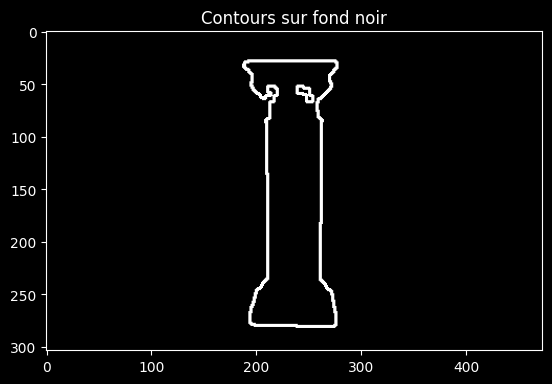

In [83]:
contours = getnShowContours(image, treshold= 20)
long_contours = [c for c in contours if len(c) > 0] if 0 > 0 else contours

# Détection des arêtes sur chaque contour
edgesContours = []
count = 0
clean_contours = [c.reshape(-1, 2) for c in long_contours]

edgesContours = []
count = 0

for c in long_contours:
    edges = edgeDetection(c, 1, stop, tresh, 10)
    edgesContours.append(edges)
edgesContours